**Movie Recommendation System**

Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

Load and Explore the Dataset

In [12]:
# Load ratings data
ratings = pd.read_csv('/content/ml-100k/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movie data
movies = pd.read_csv('/content/ml-100k/ml-100k/u.item', sep='|', encoding='latin-1',
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                            'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Drop unnecessary columns
movies = movies[['movie_id', 'title', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]

# Merge ratings and movies
data = pd.merge(ratings, movies, on='movie_id')

# Explore the data
print("Ratings Info:")
print(ratings.info())
print("\nMovies Info:")
print(movies.info())
print("\nSample Data:")
print(data[['user_id', 'title', 'rating']].head())

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     1682 non-null   int64 
 1   title        1682 non-null   object
 2   Action       1682 non-null   int64 
 3   Adventure    1682 non-null   int64 
 4   Animation    1682 non-null   int64 
 5   Children     1682 non-null   int64 
 6   Comedy       1682 non-null   int64 
 7   Crime        1682 non-null   int64 
 8   Documentary  1682 non-null   int64 
 9   Drama        1682 non-n

Data Preprocessing

In [13]:
print("Missing values in ratings:", ratings.isnull().sum())
print("Missing values in movies:", movies.isnull().sum())

Missing values in ratings: user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
Missing values in movies: movie_id       0
title          0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64


In [14]:
user_item_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print("User-Item Matrix Shape:", user_item_matrix.shape)

User-Item Matrix Shape: (943, 1682)


In [15]:
# Create a 'genres' column by combining genre columns into a single string
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

def combine_genres(row):
    genres = [col for col in genre_columns if row[col] == 1]
    return ' '.join(genres) if genres else 'Unknown'

movies['genres'] = movies.apply(combine_genres, axis=1)
print(movies[['title', 'genres']].head())

               title                     genres
0   Toy Story (1995)  Animation Children Comedy
1   GoldenEye (1995)  Action Adventure Thriller
2  Four Rooms (1995)                   Thriller
3  Get Shorty (1995)        Action Comedy Drama
4     Copycat (1995)       Crime Drama Thriller


Collaborative Filtering

In [23]:
# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index,
                                 columns=user_item_matrix.index)

# Function to get recommendations for a user
def get_collaborative_recommendations(user_id, user_item_matrix, user_similarity_df, movies, n=5):
    # Get similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:n+1].index
    # Get movies rated highly by similar users
    similar_user_ratings = user_item_matrix.loc[similar_users]
    mean_ratings = similar_user_ratings.mean(axis=0)
    # Filter out movies the user has already rated
    user_rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = mean_ratings.drop(user_rated_movies).sort_values(ascending=False).head(n)
    # Get movie titles
    recommended_movies = movies[movies['movie_id'].isin(recommendations.index)][['title']]
    return recommended_movies

# Example: Recommendations for user ID 1
print("Collaborative Filtering Recommendations for User 1:")
print(get_collaborative_recommendations(1, user_item_matrix, user_similarity_df, movies))

Collaborative Filtering Recommendations for User 1:
                                                 title
272                                        Heat (1995)
432                                    Heathers (1989)
473  Dr. Strangelove or: How I Learned to Stop Worr...
565                    Clear and Present Danger (1994)
731                                        Dave (1993)


Content-Based Filtering

In [33]:
# Initialize TF-IDF vectorizer for genres
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Calculate cosine similarity between movies
movie_similarity = cosine_similarity(tfidf_matrix)
movie_similarity_df = pd.DataFrame(movie_similarity, index=movies['movie_id'],
                                   columns=movies['movie_id'])

# Function to get content-based recommendations
def get_content_based_recommendations(movie_title, movies, movie_similarity_df, n=5):
    movie_id = movies[movies['title'] == movie_title]['movie_id'].iloc[0]
    similar_movies = movie_similarity_df[movie_id].sort_values(ascending=False)[1:n+1].index
    return movies[movies['movie_id'].isin(similar_movies)][['title']]

# Example: Recommendations for a specific movie
print("\nContent-Based Recommendations for 'Titanic (1997)':")
print(get_content_based_recommendations('Titanic (1997)', movies, movie_similarity_df))


Content-Based Recommendations for 'Titanic (1997)':
                                 title
160                     Top Gun (1986)
312                     Titanic (1997)
719                First Knight (1995)
848             Days of Thunder (1990)
1482  Man in the Iron Mask, The (1998)


Visualization

Rating Distribution

<ipython-input-34-4824f7483895>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')


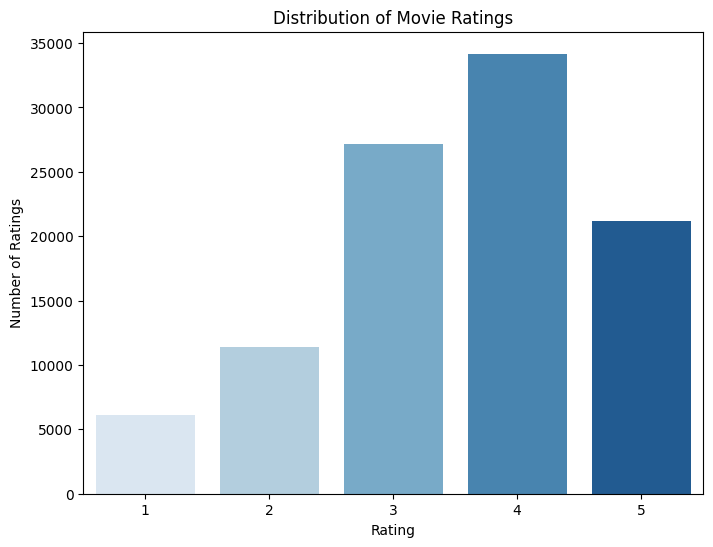

In [34]:
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

Genre Trends

<ipython-input-36-0f262b953a31>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Greens')


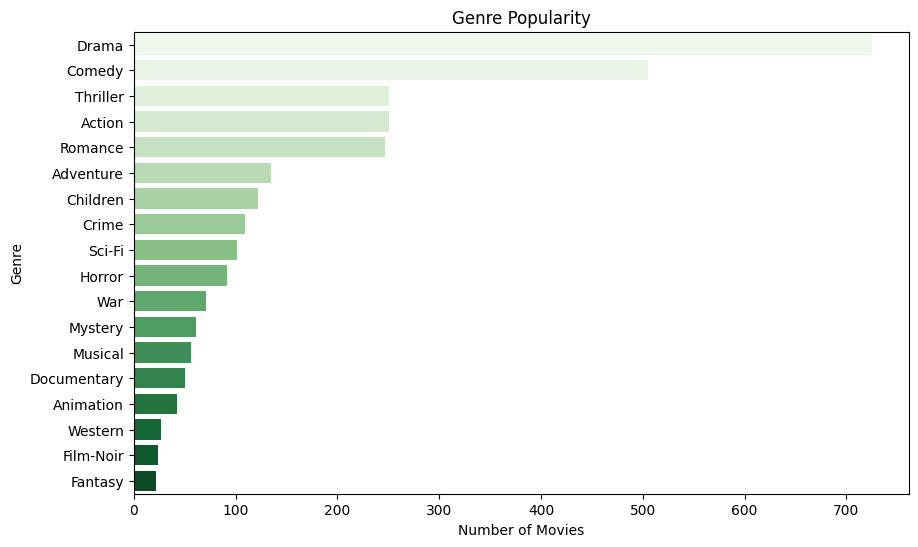

In [36]:
genre_counts = movies[genre_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Greens')
plt.title('Genre Popularity')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()